In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2,cv2

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
pycocotools 2.0.2
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
detectron2 0.2.1
cv2 4.4.0


In [17]:
import os
import numpy as np
import xml.etree.ElementTree as ET
# import cv2
import random
import itertools
import pandas as pd
import PIL.Image as Image
import torch, torchvision
import shutil 
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [3]:
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook

In [4]:
k12ai_set_notebook(cellw=95)

In [5]:
dataset = 'licenseplates'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, "images")
anno_path = os.path.join(data_root, "annotations")

In [6]:
train_fileids = np.loadtxt(os.path.join(data_root, 'train.txt'), dtype=np.str)
test_fileids = np.loadtxt(os.path.join(data_root, 'test.txt'), dtype=np.str)
all_fileids = np.concatenate((train_fileids, test_fileids))
len(train_fileids), len(test_fileids), len(all_fileids)

(102, 35, 137)

In [7]:
ann_file =  os.path.join(anno_path, f'{all_fileids[0]}.xml')
!cat $ann_file

<annotation>
    <folder>images</folder>
    <filename>105zx.jpg</filename>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>640</width>
        <height>480</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licenseplate</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>282.6</xmin>
            <ymin>209.34</ymin>
            <xmax>416.74</xmax>
            <ymax>259.26</ymax>
        </bndbox>
    </object>
</annotation>


In [9]:
data_dict = []

for fid in all_fileids:
    # img_file = os.path.join(imgs_path, f'{fid}.jpg')
    ann_file = os.path.join(anno_path, f'{fid}.xml')
    tree = ET.parse(ann_file)
    size = tree.getroot().find('size')

    d = {}
    d['file_name'] = f'{fid}.jpg'
    d['width'] = int(size.find('width').text)
    d['height'] = int(size.find('height').text)
    # d['width'] = int(tree.findall('./size/width')[0].text)
    # d['height'] = int(tree.findall('./size/height')[0].text)
    
    obj = tree.findall('object')[0]
    bndbox = obj.findall('bndbox')[0]
    
    d['x_min'] = int(float(bndbox.find('xmin').text))
    d['y_min'] = int(float(bndbox.find('ymin').text))
    d['x_max'] = int(float(bndbox.find('xmax').text))
    d['y_max'] = int(float(bndbox.find('ymax').text))
    d['class_name'] = obj.find('name').text
    data_dict.append(d)

In [10]:
df = pd.DataFrame(data_dict)

In [25]:
df.head()

file_name  width  height  x_min  y_min  x_max  y_max    class_name
0  105zx.jpg    640     480    282    209    416    259  licenseplate
1  t65qy.jpg    640     480    282    205    411    244  licenseplate
2  1vdml.jpg    640     480    278    195    427    241  licenseplate
3  5pmdj.jpg    640     480    277    172    396    209  licenseplate
4  8j6at.jpg    640     480    276    131    404    178  licenseplate

## Yolov5 data

In [41]:
# for yolo
os.system(f'mkdir -p {data_root}/yolo/images')
os.system(f'mkdir -p {data_root}/yolo/labels')

name2label = {
    'licenseplate': 0
}

def yolo_convert(d):
    dw, dh = 1.0 / d.width, 1.0 / d.height
    bw, bh = (d.x_max - d.x_min), (d.y_max - d.y_min)
    cx, cy = (d.x_min + d.x_max) / 2.0 - 1, (d.y_min + d.y_max) / 2.0 - 1
    d['x_center_norm'] = cx * dw
    d['y_center_norm'] = cy * dh
    d['b_width_norm']  = bw * dw
    d['b_height_norm'] = bh * dh
    return d

yolo_df = df.apply(yolo_convert, axis=1)

In [42]:
yolo_df.head()

file_name  width  height  x_min  y_min  x_max  y_max    class_name  \
0  105zx.jpg    640     480    282    209    416    259  licenseplate   
1  t65qy.jpg    640     480    282    205    411    244  licenseplate   
2  1vdml.jpg    640     480    278    195    427    241  licenseplate   
3  5pmdj.jpg    640     480    277    172    396    209  licenseplate   
4  8j6at.jpg    640     480    276    131    404    178  licenseplate   

   x_center_norm  y_center_norm  b_width_norm  b_height_norm  
0       0.543750       0.485417      0.209375       0.104167  
1       0.539844       0.465625      0.201563       0.081250  
2       0.549219       0.452083      0.232813       0.095833  
3       0.524219       0.394792      0.185938       0.077083  
4       0.529687       0.319792      0.200000       0.097917

In [87]:
def gen_yolo_file(df):
    for i, row in df.iterrows():
        # train
        raw_file = os.path.join(imgs_path, row.file_name)
        img_yolo = os.path.join(data_root, 'yolo/images', 'train')
        txt_yolo = os.path.join(data_root, 'yolo/labels', 'train')
        if not os.path.exists(img_yolo):
            os.makedirs(img_yolo)
            os.makedirs(txt_yolo)
        shutil.copy(raw_file, f'{img_yolo}/{row.file_name}')
        txt_name = row.file_name.split('.')[0] + '.txt' 
        txt_file = os.path.join(txt_yolo, txt_name)
        with open(txt_file, 'w') as fw:
            fw.write('0 %.6f %.6f %.6f %.6f' % (
                row.x_center_norm,
                row.y_center_norm,
                row.b_width_norm,
                row.b_height_norm
            ))
        if random.random() > 0.7:
            # val
            img_yolo = os.path.join(data_root, 'yolo/images', 'val')
            txt_yolo = os.path.join(data_root, 'yolo/labels', 'val')
            if not os.path.exists(img_yolo):
                os.mkdir(img_yolo)
                os.mkdir(txt_yolo)
            shutil.copy(raw_file, f'{img_yolo}/{row.file_name}')
            shutil.copy(txt_file, f'{txt_yolo}/{txt_name}')
    
gen_yolo_file(yolo_df) 

In [75]:
random.random()

0.7742296364701176

In [58]:
next(yolo_df.iterrows())

(0,
 file_name           105zx.jpg
 width                     640
 height                    480
 x_min                     282
 y_min                     209
 x_max                     416
 y_max                     259
 class_name       licenseplate
 x_center_norm         0.54375
 y_center_norm        0.485417
 b_width_norm         0.209375
 b_height_norm        0.104167
 Name: 0, dtype: object)

In [43]:
yolo_df.to_csv(os.path.join(data_root, 'yolo', 'annotations.csv'), header=True, index=None)

In [11]:
df.to_csv(os.path.join(data_root, 'annotations.csv'), header=True, index=None)

In [12]:
df.iloc[0].file_name, type(df.iloc[0])

('105zx.jpg', pandas.core.series.Series)

(640, 480) RGB


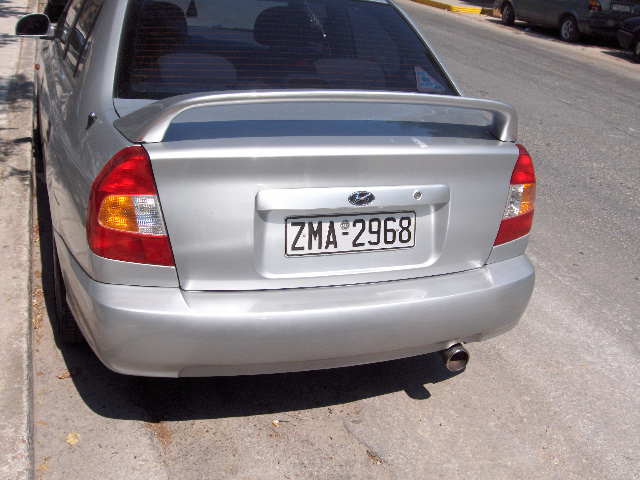

In [13]:
img = Image.open(os.path.join(imgs_path, df.iloc[0].file_name))
print(img.size, img.mode)
img

In [14]:
def annotate_image(series, resize=True):
    file_name = series.file_name
    img = cv2.cvtColor(cv2.imread(f'{imgs_path}/{file_name}'), cv2.COLOR_BGR2RGB)
    x_min, y_min, x_max, y_max = series.x_min, series.y_min, series.x_max, series.y_max
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    if not resize:
        return img

    return cv2.resize(img, (320, 240), interpolation = cv2.INTER_AREA)

(480, 640, 3)


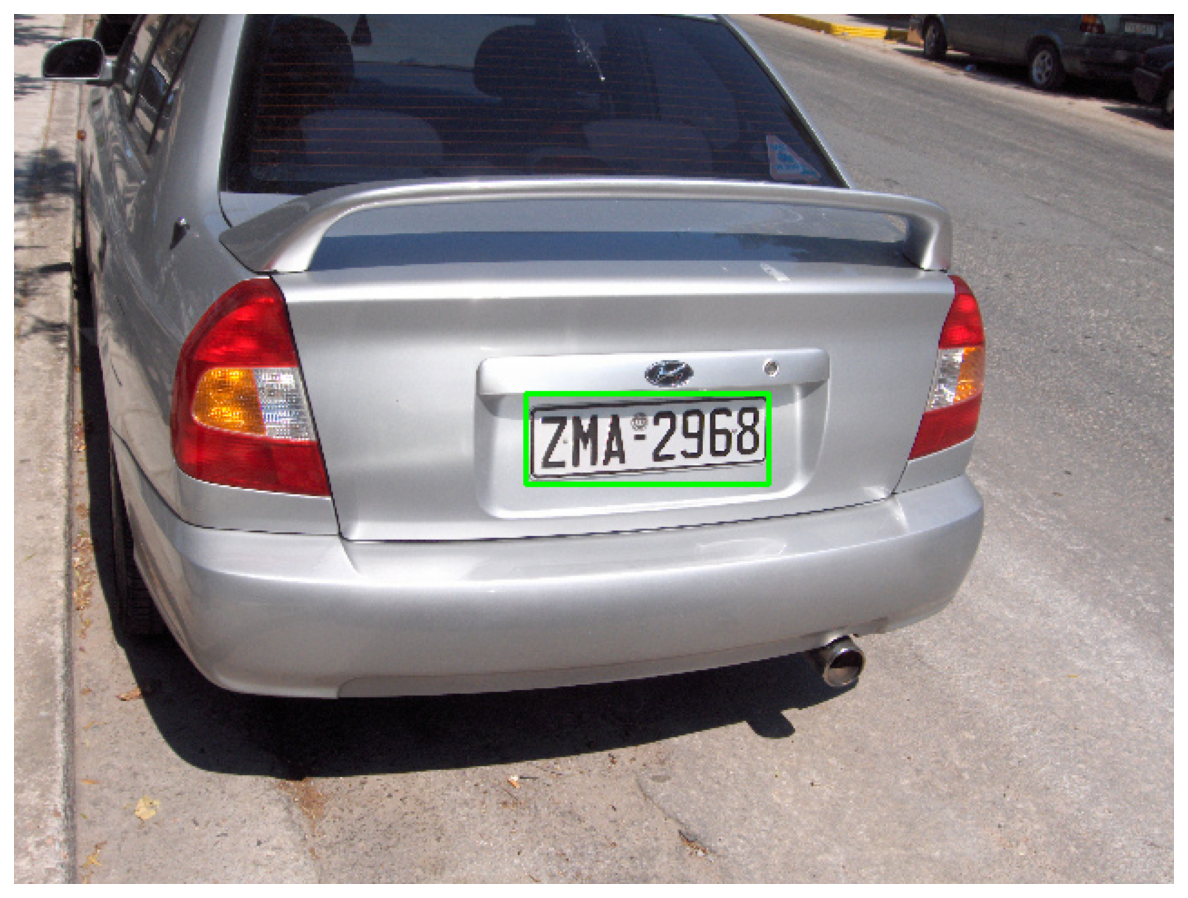

In [15]:
img = annotate_image(df.iloc[0], resize=False)
print(img.shape) # (H W C)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off');

In [16]:
sample_images = [annotate_image(d) for _, d in df[0:10].iterrows()]

In [17]:
sample_images = torch.as_tensor(sample_images)
sample_images.shape

torch.Size([10, 240, 320, 3])

In [18]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

torch.Size([10, 3, 240, 320])

torch.Size([3, 486, 1612])


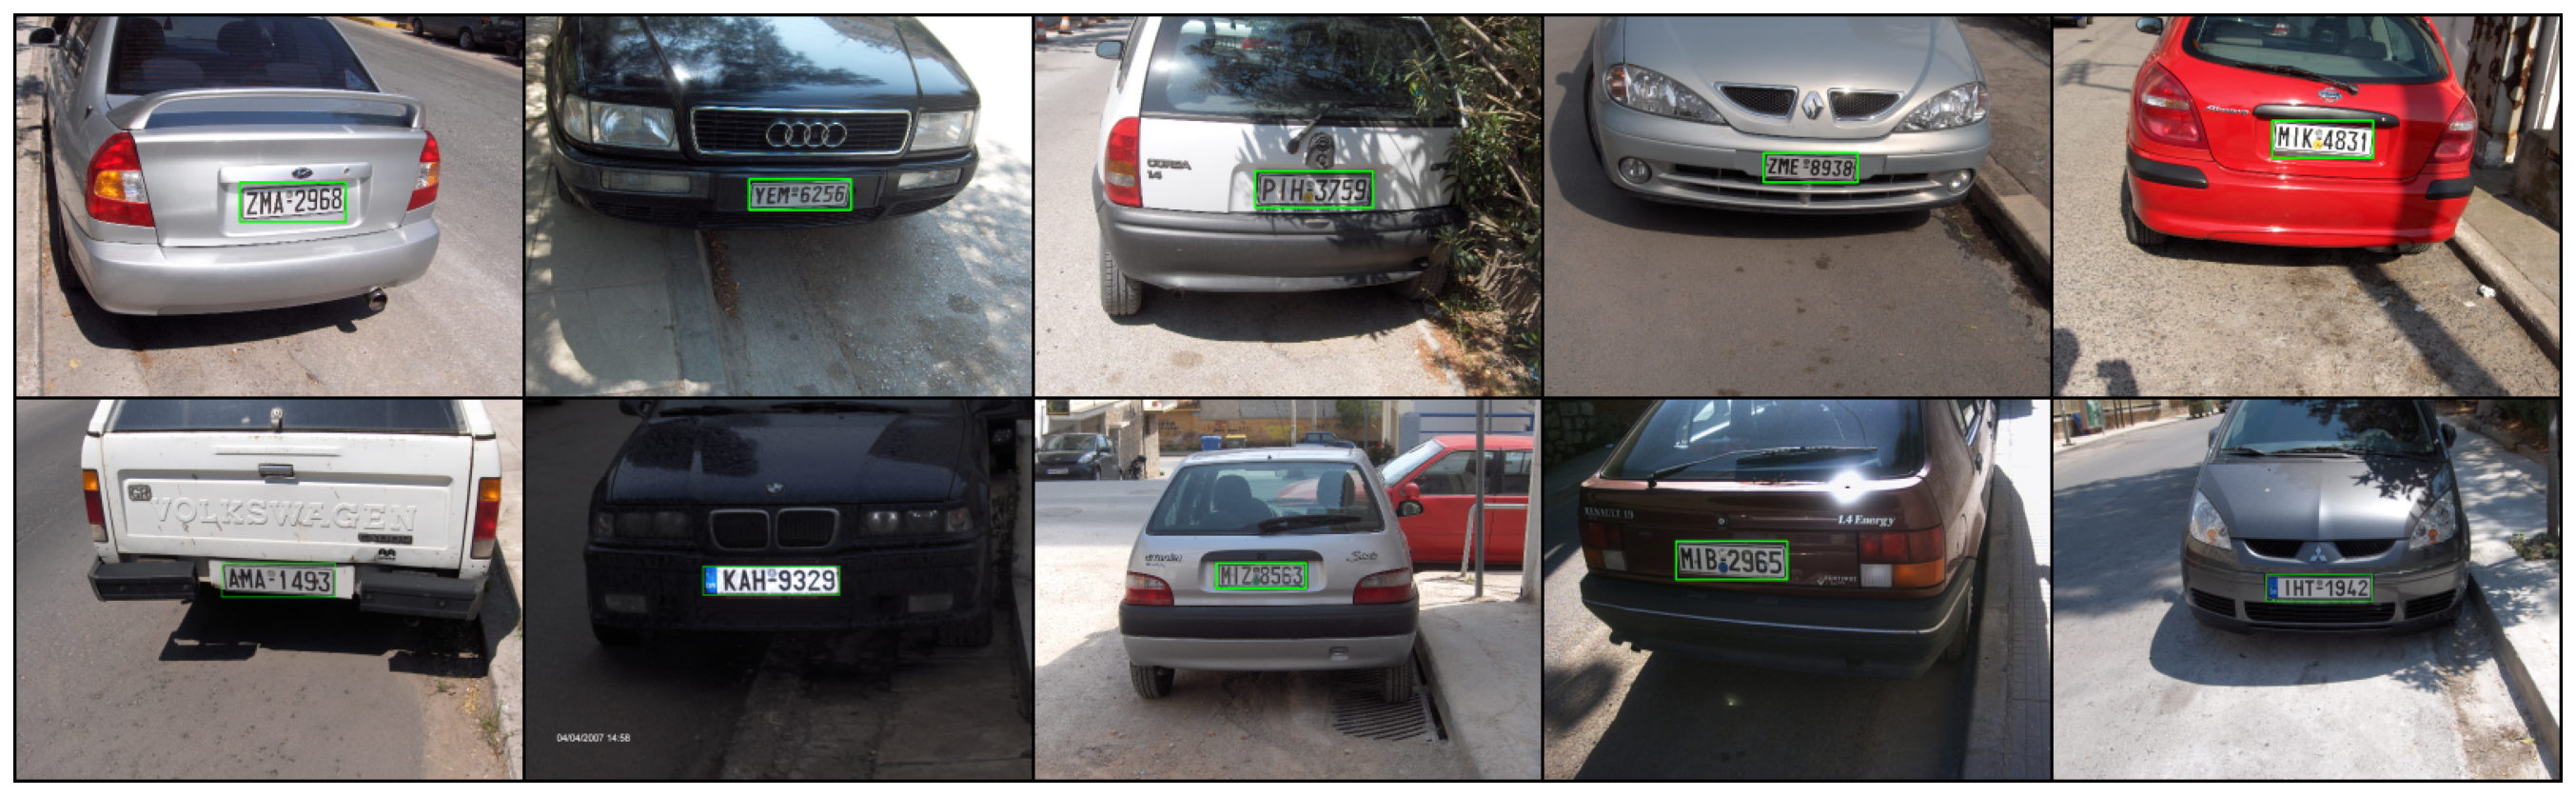

In [19]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)
print(grid_img.shape)
plt.imshow(grid_img.permute(1, 2, 0)) # to (H W C)
plt.axis('off');

## References

1. https://medium.com/deepvisionguru/train-license-plates-detection-model-using-detectron2-dd166154f604